In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image

#%load_ext pyopencl.ipython_ext
import IPython.display
import io

In [2]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

In [3]:
def make_mask(n, a=1.0):
    c = n//2
    mask = np.empty((n,n))

    for x in range(n):
        for y in range(n):
            mask[x,y] = np.exp(-((x-c)**2 + (y-c)**2) / a**2)

    return mask / mask.sum()

make_mask(3).astype(np.float32)

array([[0.04491922, 0.12210311, 0.04491922],
       [0.12210311, 0.33191067, 0.12210311],
       [0.04491922, 0.12210311, 0.04491922]], dtype=float32)

In [10]:
ax, sx = 4, 2

with open("nlmeans.cl") as fp:
    CODE = """#define AX {ax}
              #define AY {ax}
              #define SX {sx}
              #define SY {sx}
              """.format(ax=ax, sx=sx) + fp.read()

prg = cl.Program(ctx, CODE).build()

img = Image.open("lena.jpg")
img = Image.open("machine.png")
data = np.asarray(img.convert("L")).astype(np.float32)
mask = make_mask(2*3+1, a=1).astype(np.float32)
output = np.empty_like(data)
rows, cols = data.shape
h = 15.0

BLOCKS = 64
THREADS_PER_BLOCK = 64

mf = cl.mem_flags
data_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=data)
mask_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask)
output_g = cl.Buffer(ctx, mf.WRITE_ONLY, data.nbytes)

args = [data_g, output_g, mask_g, np.int32(rows), np.int32(cols), np.float32(h)]
%time prg.NLMeans_kernel(queue, (BLOCKS,), (THREADS_PER_BLOCK,), *args, g_times_l=True); cl.enqueue_copy(queue, output, output_g)

im = Image.fromarray(output.astype(np.uint8))
buf = io.BytesIO(); im.save(buf, "png"); IPython.display.Image(buf.getvalue())

FileNotFoundError: [Errno 2] No such file or directory: 'machine.jpg'

In [5]:
im = Image.fromarray(((1-mask)*255.0).astype(np.uint8))
buf = io.BytesIO(); im.save(buf, "png"); IPython.display.Image(buf.getvalue())

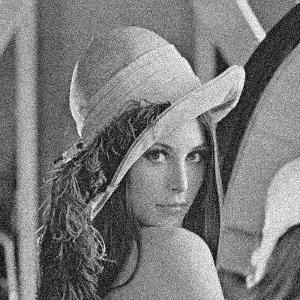

In [9]:
from nlmeans import NLMeans
import cv2

nl = NLMeans(ctx)
nl.setA(3.49)

img = Image.open("lena.jpg")
data = np.asarray(img.convert("L")).astype(np.float32)

output = nl.processImage(data)

im = Image.fromarray(output.astype(np.uint8))
buf = io.BytesIO(); im.save(buf, "png"); 
IPython.display.Image(buf.getvalue())